# Predictive Estimator Demonstration

## Preamble

In [547]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import PCNetwork as NN
import PCLayer as Layer
import importlib
import time
from IPython.display import display
from ipywidgets import FloatProgress
from copy import deepcopy
importlib.reload(NN)
importlib.reload(Layer);

if torch.cuda.is_available():
    device = torch.device("cuda:0") # Uncomment this to run on GPU
else:
    device = torch.device("cpu")
    
def MatchPlot(est, true, n=-1):
    #n = len(true)
    if n==-1:
        n = len(true)
    plt.plot(np.array(true[:n,0]), np.array(true[:n,1]), 'r.')
    plt.plot(np.array(est[:n,0]), np.array(est[:n,1]), 'b.')
    for k in range(n):
        st = [true[k,0], est[k,0]]
        en = [true[k,1], est[k,1]]
        plt.plot(st, en, 'y')

## Create a Dataset

In [665]:
# Identity
theta = 45./180.*np.pi
R = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
def RandomSample():
    r = np.random.rand(2)
    #x = np.round(r)*2. - 1
    x = 2.*r - 1.
    y = R@x #deepcopy(x)
    return [x, y]

In [252]:
# Rotation
delta_theta = 0.5 #np.pi/2.*np.random.rand()
shift = np.array([0.8, 0.])
print(delta_theta)
def RandomSample():
    r = np.random.rand(2)
    theta = r[0]*2.*np.pi
    rho = r[1]*1.8
    R = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    #x = np.round(r)*2. - 1
    x = R@np.array([rho,0]) + shift
    gamma = theta + delta_theta
    R2 = np.array([[np.cos(gamma), -np.sin(gamma)],[np.sin(gamma), np.cos(gamma)]])
    y = R2@np.array([rho,0]) #deepcopy(x)
    return [x, y]

0.5


In [253]:
training_samples = 300
training_input = []
training_output = []
for n in range(training_samples):
    r = RandomSample()
    training_input.append(np.array(r[0], dtype=float))
    training_output.append(np.array(r[1], dtype=float))

training_input = torch.tensor(training_input).float().to(device)
training_output = torch.tensor(training_output).float().to(device)
train = [training_input, training_output]

n_test_samples = 100
test_input = []
test_output = []
r = 0
for n in range(n_test_samples):
    r = RandomSample()
    test_input.append(np.array(r[0], dtype=float))
    test_output.append(np.array(r[1], dtype=float))

test_input = torch.tensor(test_input).float().to(device)
test_output = torch.tensor(test_output).float().to(device)
test = [test_input, test_output]

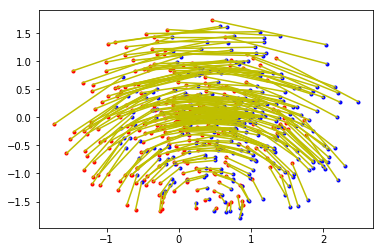

In [254]:
MatchPlot(train[0], train[1])

## Create the Neural Network

In [576]:
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=2))
net.AddLayer(Layer.PELayer(n=2))
net.AddLayer(Layer.TopPELayer(n=2))
net.Connect(0,1, act='identity')
net.Connect(1,2, act='identity')

identity
identity


In [576]:
net = NN.PCNetwork()
net.AddLayer(Layer.StimulusPELayer(n=2))
net.AddLayer(Layer.PELayer(n=2))
net.AddLayer(Layer.TargetPELayer(n=2))
net.Connect(predictor=0, evaluator=1, act='identity')
net.Connect(predictor=1, evaluator=2, act='identity')

identity
identity


In [577]:
net_orig = deepcopy(net)

In [578]:
net.connections[0].MakeIdentity()
net.connections[1].MakeIdentity()
print(net.connections[1].W)
net.learn_weights = False
net.layers[0].b[0] = 0.8
print(net.layers[0].b)

tensor([[ 1.,  0.],
        [ 0.,  1.]])
tensor([ 0.8000,  0.0000])


## Pre-Training Performance

In [579]:
net.Reset()
yy = net.Predict(1., train[0][:5])

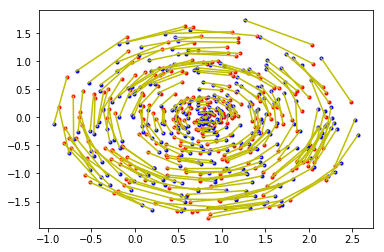

In [580]:
mu = net.BackprojectExpectation(train[1])
MatchPlot(mu, train[0])

## Train

A Jupyter Widget

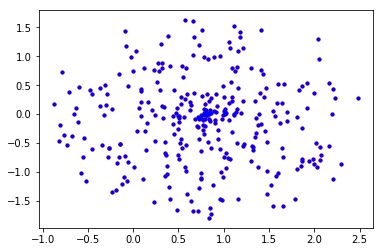

In [582]:
net.l_rate = 0.0002
net.FastLearn(train[0], train[1], T=50, epochs=100, batch_size=20)

mu = net.BackprojectExpectation(train[1])
MatchPlot(mu, train[0])

## Save and/or Load the Model

In [583]:
net.Save('Rotation.npy')

In [60]:
net = NN.NeuralNetwork()
net.Load('Rotation.npy')

## Test Forward Direction

In [584]:
net.Reset()
yc = deepcopy(net.Predict(10., train[0]))

In [585]:
net.Reset()
yf = deepcopy(net.FastPredict(train[0], T=40))

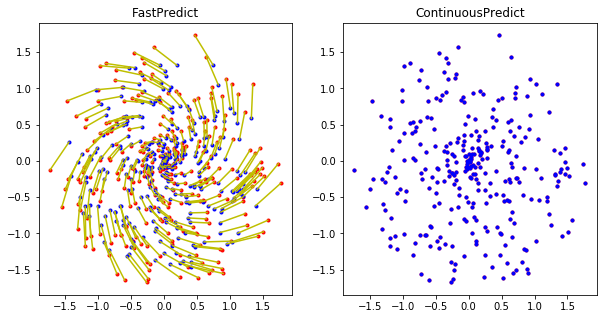

In [586]:
plt.figure(figsize=[10,5]);
plt.subplot(1,2,1); MatchPlot(yf, train[1]); plt.title('FastPredict');
plt.subplot(1,2,2); MatchPlot(yc, train[1]); plt.title('ContinuousPredict');

## Backward Direction

In [56]:
xx = net.Generate(10., test[1])

In [57]:
xx = net.BackprojectExpectation(test[1])

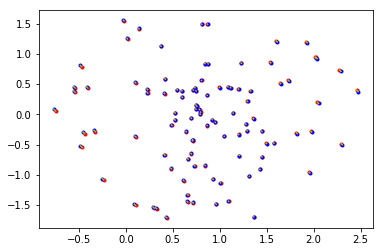

In [58]:
MatchPlot(xx, test[0])